This is one of submissions on "Journey to Springfield" task from Deep Learning School course. Overall score 0.98

To solve the task, I used a pretrained ResNet18 model with SGD and a ReduceLROnPlateau scheduler, a variation of oversampling on the original data, and model bagging using K-fold cross-validation. 

Overall score 1

### Imports

In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

### Constants

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 5

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# SimpsonsDataset 

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование, трансформацию учебных данных и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
"""
Классы, содержащие меньше 100 картинок, дополняются копиями до 100
"""
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


### Constracting learninh procedures

In [7]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=3, verbose=False)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_acc)
                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Model schema

In [8]:
n_classes = len(np.unique(train_val_labels))
clf = models.resnet18(pretrained=True)

for param in clf.parameters():
    param.requires_grad = False
    
clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
clf = clf.to('cuda')
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
submit = pd.DataFrame(columns=['Id'])


FOLD 1



epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.977460364154585


epoch:   3%|██▌                                                                        | 1/30 [01:55<55:43, 115.29s/it]


Epoch 001 train_loss: 1.9775     val_loss 0.9849 train_acc 0.5446 val_acc 0.7798
loss 0.5992413675010944


epoch:   7%|█████                                                                      | 2/30 [03:48<53:30, 114.65s/it]


Epoch 002 train_loss: 0.5992     val_loss 0.4410 train_acc 0.8457 val_acc 0.8883
loss 0.31033963081266014


epoch:  10%|███████▌                                                                   | 3/30 [05:39<51:09, 113.70s/it]


Epoch 003 train_loss: 0.3103     val_loss 0.3186 train_acc 0.9192 val_acc 0.9214
loss 0.21033511890002815


epoch:  13%|██████████                                                                 | 4/30 [07:33<49:11, 113.53s/it]


Epoch 004 train_loss: 0.2103     val_loss 0.2737 train_acc 0.9452 val_acc 0.9265
loss 0.15504095013879396


epoch:  17%|████████████▌                                                              | 5/30 [09:26<47:14, 113.37s/it]


Epoch 005 train_loss: 0.1550     val_loss 0.2226 train_acc 0.9589 val_acc 0.9450
loss 0.12364058942581423


epoch:  20%|███████████████                                                            | 6/30 [11:21<45:38, 114.09s/it]


Epoch 006 train_loss: 0.1236     val_loss 0.2060 train_acc 0.9681 val_acc 0.9475
loss 0.10103173095819522


epoch:  23%|█████████████████▌                                                         | 7/30 [13:11<43:13, 112.77s/it]


Epoch 007 train_loss: 0.1010     val_loss 0.1944 train_acc 0.9732 val_acc 0.9513
loss 0.07871572044921382


epoch:  27%|████████████████████                                                       | 8/30 [15:04<41:24, 112.91s/it]


Epoch 008 train_loss: 0.0787     val_loss 0.2125 train_acc 0.9786 val_acc 0.9475
loss 0.06700361571072838


epoch:  30%|██████████████████████▌                                                    | 9/30 [17:06<40:27, 115.60s/it]


Epoch 009 train_loss: 0.0670     val_loss 0.2215 train_acc 0.9826 val_acc 0.9495
loss 0.05503913444974917


epoch:  33%|████████████████████████▋                                                 | 10/30 [19:07<39:04, 117.24s/it]


Epoch 010 train_loss: 0.0550     val_loss 0.1736 train_acc 0.9853 val_acc 0.9607
loss 0.04819697760365951


epoch:  37%|███████████████████████████▏                                              | 11/30 [21:14<38:04, 120.23s/it]


Epoch 011 train_loss: 0.0482     val_loss 0.1737 train_acc 0.9871 val_acc 0.9591
loss 0.03902297766461758


epoch:  40%|█████████████████████████████▌                                            | 12/30 [23:21<36:37, 122.06s/it]


Epoch 012 train_loss: 0.0390     val_loss 0.2147 train_acc 0.9902 val_acc 0.9511
loss 0.033484423269147884


epoch:  43%|████████████████████████████████                                          | 13/30 [25:23<34:35, 122.08s/it]


Epoch 013 train_loss: 0.0335     val_loss 0.1724 train_acc 0.9909 val_acc 0.9591
loss 0.0318063925423


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [27:26<32:37, 122.37s/it]


Epoch 014 train_loss: 0.0318     val_loss 0.1752 train_acc 0.9909 val_acc 0.9630
loss 0.027031366811695354


epoch:  50%|█████████████████████████████████████                                     | 15/30 [29:33<30:55, 123.69s/it]


Epoch 015 train_loss: 0.0270     val_loss 0.1853 train_acc 0.9930 val_acc 0.9566
loss 0.02138423593031328


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [31:26<28:08, 120.64s/it]


Epoch 016 train_loss: 0.0214     val_loss 0.1751 train_acc 0.9947 val_acc 0.9639
loss 0.018905745834317273


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [33:17<25:28, 117.58s/it]


Epoch 017 train_loss: 0.0189     val_loss 0.1660 train_acc 0.9943 val_acc 0.9648
loss 0.02217468599088797


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [35:06<23:00, 115.02s/it]


Epoch 018 train_loss: 0.0222     val_loss 0.2011 train_acc 0.9937 val_acc 0.9568
loss 0.012500722660702563


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [36:55<20:45, 113.25s/it]


Epoch 019 train_loss: 0.0125     val_loss 0.1886 train_acc 0.9965 val_acc 0.9616
loss 0.01354049758003093


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [38:44<18:40, 112.01s/it]


Epoch 020 train_loss: 0.0135     val_loss 0.1766 train_acc 0.9963 val_acc 0.9619
loss 0.01484407249196789


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [40:33<16:40, 111.15s/it]


Epoch 021 train_loss: 0.0148     val_loss 0.1850 train_acc 0.9958 val_acc 0.9646
loss 0.004910434522655651


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [42:22<14:44, 110.62s/it]


Epoch 022 train_loss: 0.0049     val_loss 0.1628 train_acc 0.9987 val_acc 0.9685
loss 0.0034215123338333453


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [44:12<12:51, 110.21s/it]


Epoch 023 train_loss: 0.0034     val_loss 0.1579 train_acc 0.9992 val_acc 0.9676
loss 0.0024008635714291857


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [46:01<10:59, 109.95s/it]


Epoch 024 train_loss: 0.0024     val_loss 0.1586 train_acc 0.9994 val_acc 0.9708
loss 0.003259460360538745


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [47:50<09:08, 109.69s/it]


Epoch 025 train_loss: 0.0033     val_loss 0.1688 train_acc 0.9991 val_acc 0.9687
loss 0.0018820196972700657


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [49:39<07:18, 109.52s/it]


Epoch 026 train_loss: 0.0019     val_loss 0.1689 train_acc 0.9997 val_acc 0.9698
loss 0.002288218997201595


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [51:28<05:28, 109.43s/it]


Epoch 027 train_loss: 0.0023     val_loss 0.1733 train_acc 0.9994 val_acc 0.9694
loss 0.0033192603807757864


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [53:18<03:38, 109.31s/it]


Epoch 028 train_loss: 0.0033     val_loss 0.1585 train_acc 0.9991 val_acc 0.9701
loss 0.001538501896151784


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [55:07<01:49, 109.25s/it]


Epoch 029 train_loss: 0.0015     val_loss 0.1723 train_acc 0.9997 val_acc 0.9701
loss 0.0019712413805551654


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [56:56<00:00, 113.88s/it]


Epoch 030 train_loss: 0.0020     val_loss 0.1661 train_acc 0.9996 val_acc 0.9698


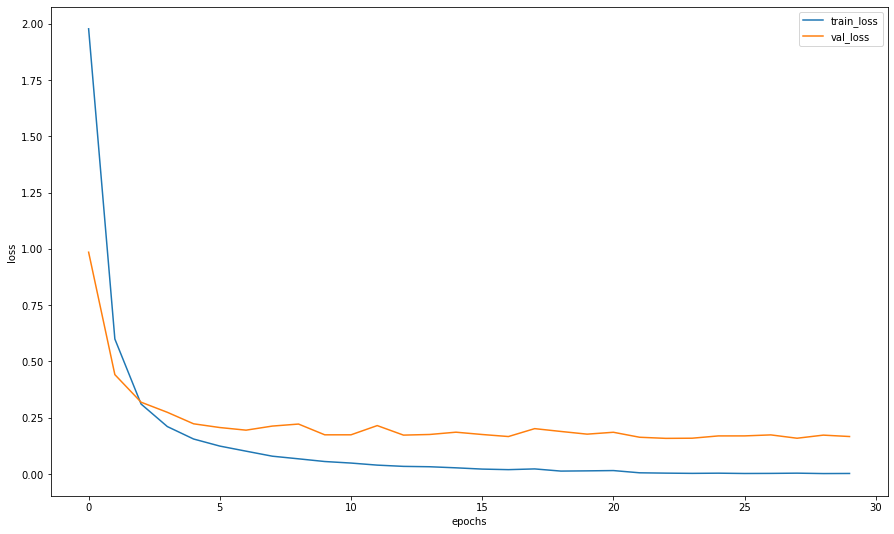


FOLD 2



epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.994536973327931


epoch:   3%|██▌                                                                        | 1/30 [01:50<53:36, 110.91s/it]


Epoch 001 train_loss: 1.9945     val_loss 0.9809 train_acc 0.5423 val_acc 0.7869
loss 0.6004284428031204


epoch:   7%|█████                                                                      | 2/30 [03:41<51:40, 110.73s/it]


Epoch 002 train_loss: 0.6004     val_loss 0.4277 train_acc 0.8463 val_acc 0.8901
loss 0.3065862123575684


epoch:  10%|███████▌                                                                   | 3/30 [05:33<49:59, 111.10s/it]


Epoch 003 train_loss: 0.3066     val_loss 0.2768 train_acc 0.9203 val_acc 0.9296
loss 0.20978258357828147


epoch:  13%|██████████                                                                 | 4/30 [07:22<47:54, 110.57s/it]


Epoch 004 train_loss: 0.2098     val_loss 0.2175 train_acc 0.9453 val_acc 0.9463
loss 0.15190372411756337


epoch:  17%|████████████▌                                                              | 5/30 [09:12<45:59, 110.37s/it]


Epoch 005 train_loss: 0.1519     val_loss 0.2145 train_acc 0.9606 val_acc 0.9504
loss 0.11806292190711212


epoch:  20%|███████████████                                                            | 6/30 [11:01<44:01, 110.04s/it]


Epoch 006 train_loss: 0.1181     val_loss 0.2034 train_acc 0.9674 val_acc 0.9550
loss 0.10202112627817328


epoch:  23%|█████████████████▌                                                         | 7/30 [12:51<42:06, 109.86s/it]


Epoch 007 train_loss: 0.1020     val_loss 0.1830 train_acc 0.9731 val_acc 0.9593
loss 0.07751522685695661


epoch:  27%|████████████████████                                                       | 8/30 [14:40<40:13, 109.71s/it]


Epoch 008 train_loss: 0.0775     val_loss 0.1961 train_acc 0.9793 val_acc 0.9573
loss 0.0624827235023083


epoch:  30%|██████████████████████▌                                                    | 9/30 [16:30<38:23, 109.67s/it]


Epoch 009 train_loss: 0.0625     val_loss 0.1871 train_acc 0.9832 val_acc 0.9600
loss 0.051245295618237825


epoch:  33%|████████████████████████▋                                                 | 10/30 [18:19<36:33, 109.66s/it]


Epoch 010 train_loss: 0.0512     val_loss 0.1710 train_acc 0.9861 val_acc 0.9641
loss 0.041354653360329036


epoch:  37%|███████████████████████████▏                                              | 11/30 [20:09<34:42, 109.59s/it]


Epoch 011 train_loss: 0.0414     val_loss 0.1964 train_acc 0.9882 val_acc 0.9593
loss 0.0365282680926108


epoch:  40%|█████████████████████████████▌                                            | 12/30 [21:58<32:51, 109.53s/it]


Epoch 012 train_loss: 0.0365     val_loss 0.1838 train_acc 0.9894 val_acc 0.9648
loss 0.03467127793283616


epoch:  43%|████████████████████████████████                                          | 13/30 [23:48<31:01, 109.52s/it]


Epoch 013 train_loss: 0.0347     val_loss 0.1817 train_acc 0.9906 val_acc 0.9625
loss 0.02777591210248653


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [25:37<29:12, 109.53s/it]


Epoch 014 train_loss: 0.0278     val_loss 0.1742 train_acc 0.9925 val_acc 0.9669
loss 0.023495757550520448


epoch:  50%|█████████████████████████████████████                                     | 15/30 [27:27<27:23, 109.55s/it]


Epoch 015 train_loss: 0.0235     val_loss 0.1765 train_acc 0.9935 val_acc 0.9657
loss 0.02108519887481985


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [29:16<25:34, 109.58s/it]


Epoch 016 train_loss: 0.0211     val_loss 0.2320 train_acc 0.9941 val_acc 0.9516
loss 0.01765482802661246


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [31:06<23:46, 109.74s/it]


Epoch 017 train_loss: 0.0177     val_loss 0.1957 train_acc 0.9949 val_acc 0.9662
loss 0.01489351409737903


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [32:56<21:56, 109.67s/it]


Epoch 018 train_loss: 0.0149     val_loss 0.1890 train_acc 0.9957 val_acc 0.9648
loss 0.007688542587207715


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [34:45<20:05, 109.56s/it]


Epoch 019 train_loss: 0.0077     val_loss 0.1737 train_acc 0.9982 val_acc 0.9719
loss 0.004563679679597799


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [36:35<18:16, 109.68s/it]


Epoch 020 train_loss: 0.0046     val_loss 0.1680 train_acc 0.9993 val_acc 0.9728
loss 0.004076244802619202


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [38:26<16:30, 110.05s/it]


Epoch 021 train_loss: 0.0041     val_loss 0.1823 train_acc 0.9989 val_acc 0.9728
loss 0.004346036701363429


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [40:16<14:39, 109.93s/it]


Epoch 022 train_loss: 0.0043     val_loss 0.1858 train_acc 0.9990 val_acc 0.9717
loss 0.0031149324585171786


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [42:05<12:49, 109.87s/it]


Epoch 023 train_loss: 0.0031     val_loss 0.1850 train_acc 0.9994 val_acc 0.9724
loss 0.002532124076532425


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [43:55<10:58, 109.77s/it]


Epoch 024 train_loss: 0.0025     val_loss 0.1891 train_acc 0.9993 val_acc 0.9717
loss 0.0025653930617068926


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [45:45<09:08, 109.77s/it]


Epoch 025 train_loss: 0.0026     val_loss 0.1904 train_acc 0.9993 val_acc 0.9726
loss 0.002439526162430998


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [47:35<07:19, 109.83s/it]


Epoch 026 train_loss: 0.0024     val_loss 0.2001 train_acc 0.9991 val_acc 0.9694
loss 0.0028859956375093332


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [49:25<05:29, 109.81s/it]


Epoch 027 train_loss: 0.0029     val_loss 0.1935 train_acc 0.9993 val_acc 0.9728
loss 0.0023196647041825932


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [51:14<03:39, 109.72s/it]


Epoch 028 train_loss: 0.0023     val_loss 0.1928 train_acc 0.9993 val_acc 0.9705
loss 0.002296107548927932


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [53:03<01:49, 109.62s/it]


Epoch 029 train_loss: 0.0023     val_loss 0.1907 train_acc 0.9993 val_acc 0.9721
loss 0.0018374640063471355


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [54:53<00:00, 109.78s/it]


Epoch 030 train_loss: 0.0018     val_loss 0.1937 train_acc 0.9996 val_acc 0.9719


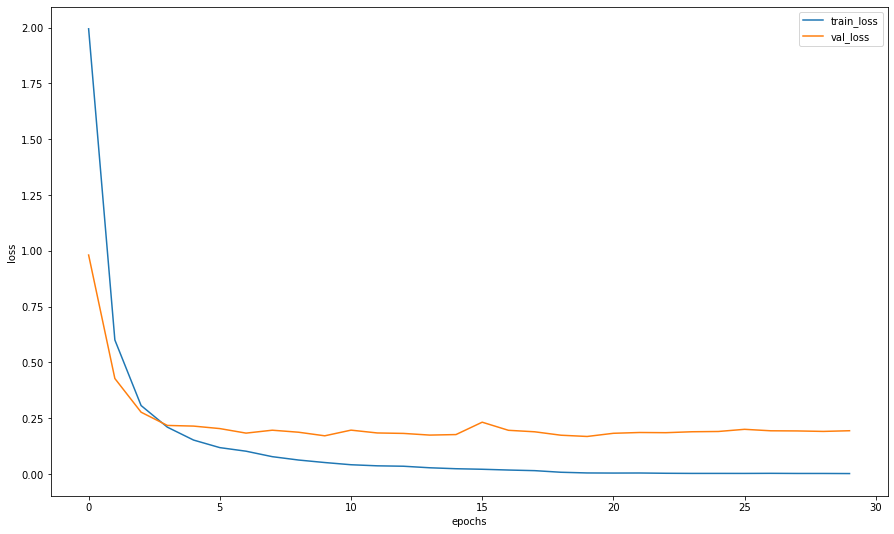


FOLD 3



epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.9156825100197783


epoch:   3%|██▌                                                                        | 1/30 [01:51<53:41, 111.08s/it]


Epoch 001 train_loss: 1.9157     val_loss 0.9450 train_acc 0.5661 val_acc 0.7942
loss 0.5899563166361275


epoch:   7%|█████                                                                      | 2/30 [03:40<51:38, 110.66s/it]


Epoch 002 train_loss: 0.5900     val_loss 0.4288 train_acc 0.8471 val_acc 0.8915
loss 0.30365049403473554


epoch:  10%|███████▌                                                                   | 3/30 [05:30<49:41, 110.42s/it]


Epoch 003 train_loss: 0.3037     val_loss 0.2828 train_acc 0.9210 val_acc 0.9253
loss 0.20980384605465993


epoch:  13%|██████████                                                                 | 4/30 [07:20<47:45, 110.22s/it]


Epoch 004 train_loss: 0.2098     val_loss 0.2304 train_acc 0.9436 val_acc 0.9397
loss 0.15601175386545862


epoch:  17%|████████████▌                                                              | 5/30 [09:10<45:53, 110.15s/it]


Epoch 005 train_loss: 0.1560     val_loss 0.2090 train_acc 0.9595 val_acc 0.9477
loss 0.126140074509338


epoch:  20%|███████████████                                                            | 6/30 [10:59<43:58, 109.96s/it]


Epoch 006 train_loss: 0.1261     val_loss 0.2401 train_acc 0.9654 val_acc 0.9381
loss 0.1024662761271919


epoch:  23%|█████████████████▌                                                         | 7/30 [12:49<42:08, 109.93s/it]


Epoch 007 train_loss: 0.1025     val_loss 0.1968 train_acc 0.9742 val_acc 0.9509
loss 0.0802475964951556


epoch:  27%|████████████████████                                                       | 8/30 [14:39<40:18, 109.92s/it]


Epoch 008 train_loss: 0.0802     val_loss 0.1649 train_acc 0.9786 val_acc 0.9596
loss 0.07217695396468


epoch:  30%|██████████████████████▌                                                    | 9/30 [16:29<38:25, 109.80s/it]


Epoch 009 train_loss: 0.0722     val_loss 0.2099 train_acc 0.9805 val_acc 0.9465
loss 0.0574683409973262


epoch:  33%|████████████████████████▋                                                 | 10/30 [18:18<36:34, 109.72s/it]


Epoch 010 train_loss: 0.0575     val_loss 0.1685 train_acc 0.9854 val_acc 0.9628
loss 0.043742453308402644


epoch:  37%|███████████████████████████▏                                              | 11/30 [20:08<34:44, 109.71s/it]


Epoch 011 train_loss: 0.0437     val_loss 0.1612 train_acc 0.9882 val_acc 0.9625
loss 0.04048560895211888


epoch:  40%|█████████████████████████████▌                                            | 12/30 [21:58<32:54, 109.70s/it]


Epoch 012 train_loss: 0.0405     val_loss 0.1859 train_acc 0.9891 val_acc 0.9586
loss 0.033549026622602354


epoch:  43%|████████████████████████████████                                          | 13/30 [23:47<31:05, 109.74s/it]


Epoch 013 train_loss: 0.0335     val_loss 0.1922 train_acc 0.9907 val_acc 0.9589
loss 0.027874018721227165


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [25:37<29:14, 109.64s/it]


Epoch 014 train_loss: 0.0279     val_loss 0.1949 train_acc 0.9929 val_acc 0.9605
loss 0.009637627024219496


epoch:  50%|█████████████████████████████████████                                     | 15/30 [27:26<27:24, 109.61s/it]


Epoch 015 train_loss: 0.0096     val_loss 0.1469 train_acc 0.9975 val_acc 0.9701
loss 0.0069808210259561946


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [29:16<25:35, 109.66s/it]


Epoch 016 train_loss: 0.0070     val_loss 0.1537 train_acc 0.9985 val_acc 0.9687
loss 0.005211052521503451


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [31:06<23:44, 109.61s/it]


Epoch 017 train_loss: 0.0052     val_loss 0.1457 train_acc 0.9988 val_acc 0.9698
loss 0.005883799819235846


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [32:55<21:55, 109.62s/it]


Epoch 018 train_loss: 0.0059     val_loss 0.1598 train_acc 0.9986 val_acc 0.9714
loss 0.005783779317697139


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [34:45<20:06, 109.72s/it]


Epoch 019 train_loss: 0.0058     val_loss 0.1654 train_acc 0.9987 val_acc 0.9703
loss 0.003967554347394412


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [36:35<18:17, 109.78s/it]


Epoch 020 train_loss: 0.0040     val_loss 0.1558 train_acc 0.9992 val_acc 0.9726
loss 0.004214832239468097


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [38:25<16:27, 109.74s/it]


Epoch 021 train_loss: 0.0042     val_loss 0.1540 train_acc 0.9993 val_acc 0.9744
loss 0.004426193700263358


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [40:15<14:38, 109.75s/it]


Epoch 022 train_loss: 0.0044     val_loss 0.1678 train_acc 0.9991 val_acc 0.9673
loss 0.004115739486872754


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [42:04<12:47, 109.71s/it]


Epoch 023 train_loss: 0.0041     val_loss 0.1623 train_acc 0.9991 val_acc 0.9694
loss 0.004629928925458123


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [43:54<10:58, 109.74s/it]


Epoch 024 train_loss: 0.0046     val_loss 0.1703 train_acc 0.9989 val_acc 0.9708
loss 0.003193923774792859


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [45:44<09:08, 109.76s/it]


Epoch 025 train_loss: 0.0032     val_loss 0.1746 train_acc 0.9994 val_acc 0.9680
loss 0.003720628840770085


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [47:34<07:19, 109.77s/it]


Epoch 026 train_loss: 0.0037     val_loss 0.1599 train_acc 0.9992 val_acc 0.9689
loss 0.004350265946988121


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [49:23<05:29, 109.76s/it]


Epoch 027 train_loss: 0.0044     val_loss 0.1670 train_acc 0.9993 val_acc 0.9712
loss 0.0033891713258271546


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [51:13<03:39, 109.68s/it]


Epoch 028 train_loss: 0.0034     val_loss 0.1674 train_acc 0.9993 val_acc 0.9710
loss 0.00419471643773758


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [53:02<01:49, 109.68s/it]


Epoch 029 train_loss: 0.0042     val_loss 0.1669 train_acc 0.9990 val_acc 0.9724
loss 0.0037365748635899776


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [54:52<00:00, 109.76s/it]


Epoch 030 train_loss: 0.0037     val_loss 0.1635 train_acc 0.9993 val_acc 0.9730


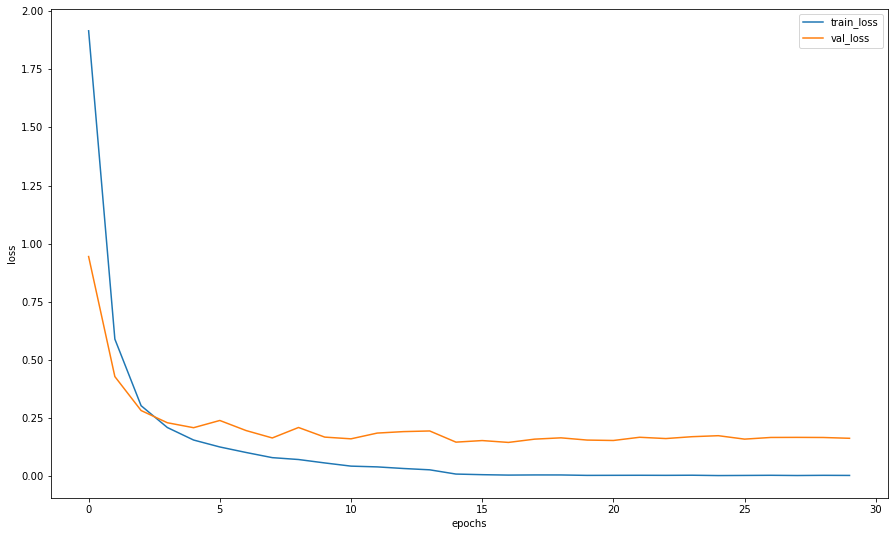


FOLD 4



epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.9442688486699988


epoch:   3%|██▌                                                                        | 1/30 [01:51<53:40, 111.04s/it]


Epoch 001 train_loss: 1.9443     val_loss 0.9506 train_acc 0.5592 val_acc 0.7921
loss 0.5904931560711885


epoch:   7%|█████                                                                      | 2/30 [03:40<51:38, 110.66s/it]


Epoch 002 train_loss: 0.5905     val_loss 0.3826 train_acc 0.8492 val_acc 0.8976
loss 0.2966144558363544


epoch:  10%|███████▌                                                                   | 3/30 [05:30<49:38, 110.33s/it]


Epoch 003 train_loss: 0.2966     val_loss 0.2915 train_acc 0.9242 val_acc 0.9189
loss 0.21530494910012238


epoch:  13%|██████████                                                                 | 4/30 [07:20<47:46, 110.23s/it]


Epoch 004 train_loss: 0.2153     val_loss 0.2441 train_acc 0.9453 val_acc 0.9367
loss 0.160259438926904


epoch:  17%|████████████▌                                                              | 5/30 [09:10<45:51, 110.06s/it]


Epoch 005 train_loss: 0.1603     val_loss 0.2188 train_acc 0.9589 val_acc 0.9397
loss 0.13123588964879207


epoch:  20%|███████████████                                                            | 6/30 [10:59<43:57, 109.91s/it]


Epoch 006 train_loss: 0.1312     val_loss 0.2013 train_acc 0.9657 val_acc 0.9507
loss 0.09553145718240078


epoch:  23%|█████████████████▌                                                         | 7/30 [12:49<42:07, 109.91s/it]


Epoch 007 train_loss: 0.0955     val_loss 0.1893 train_acc 0.9763 val_acc 0.9538
loss 0.08060345926509797


epoch:  27%|████████████████████                                                       | 8/30 [14:39<40:18, 109.91s/it]


Epoch 008 train_loss: 0.0806     val_loss 0.2156 train_acc 0.9792 val_acc 0.9436
loss 0.06780560002335136


epoch:  30%|██████████████████████▌                                                    | 9/30 [16:29<38:26, 109.83s/it]


Epoch 009 train_loss: 0.0678     val_loss 0.1592 train_acc 0.9831 val_acc 0.9630
loss 0.05644062041538501


epoch:  33%|████████████████████████▋                                                 | 10/30 [18:19<36:37, 109.87s/it]


Epoch 010 train_loss: 0.0564     val_loss 0.1943 train_acc 0.9840 val_acc 0.9518
loss 0.053269055283185346


epoch:  37%|███████████████████████████▏                                              | 11/30 [20:08<34:47, 109.85s/it]


Epoch 011 train_loss: 0.0533     val_loss 0.1795 train_acc 0.9858 val_acc 0.9543
loss 0.037840661249505934


epoch:  40%|█████████████████████████████▌                                            | 12/30 [21:58<32:55, 109.73s/it]


Epoch 012 train_loss: 0.0378     val_loss 0.1540 train_acc 0.9894 val_acc 0.9644
loss 0.036289214216378


epoch:  43%|████████████████████████████████                                          | 13/30 [23:48<31:06, 109.82s/it]


Epoch 013 train_loss: 0.0363     val_loss 0.1739 train_acc 0.9900 val_acc 0.9586
loss 0.028152276369195744


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [25:37<29:16, 109.78s/it]


Epoch 014 train_loss: 0.0282     val_loss 0.1553 train_acc 0.9925 val_acc 0.9655
loss 0.02459187237349052


epoch:  50%|█████████████████████████████████████                                     | 15/30 [27:27<27:26, 109.76s/it]


Epoch 015 train_loss: 0.0246     val_loss 0.1645 train_acc 0.9936 val_acc 0.9630
loss 0.022452262021826718


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [29:17<25:37, 109.84s/it]


Epoch 016 train_loss: 0.0225     val_loss 0.1882 train_acc 0.9939 val_acc 0.9552
loss 0.016896722685659504


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [31:07<23:47, 109.80s/it]


Epoch 017 train_loss: 0.0169     val_loss 0.2307 train_acc 0.9956 val_acc 0.9495
loss 0.017952567737188927


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [32:57<21:58, 109.85s/it]


Epoch 018 train_loss: 0.0180     val_loss 0.1618 train_acc 0.9950 val_acc 0.9696
loss 0.015188705437986349


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [34:47<20:08, 109.87s/it]


Epoch 019 train_loss: 0.0152     val_loss 0.1806 train_acc 0.9960 val_acc 0.9600
loss 0.0135284141565714


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [36:36<18:17, 109.77s/it]


Epoch 020 train_loss: 0.0135     val_loss 0.1988 train_acc 0.9961 val_acc 0.9612
loss 0.016426825455083022


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [38:26<16:27, 109.72s/it]


Epoch 021 train_loss: 0.0164     val_loss 0.1655 train_acc 0.9948 val_acc 0.9671
loss 0.012232329054360759


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [40:16<14:37, 109.66s/it]


Epoch 022 train_loss: 0.0122     val_loss 0.1523 train_acc 0.9965 val_acc 0.9701
loss 0.009019884663043083


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [42:05<12:48, 109.74s/it]


Epoch 023 train_loss: 0.0090     val_loss 0.1790 train_acc 0.9977 val_acc 0.9641
loss 0.010436410511573133


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [43:55<10:58, 109.80s/it]


Epoch 024 train_loss: 0.0104     val_loss 0.1672 train_acc 0.9969 val_acc 0.9698
loss 0.009864118533487672


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [45:46<09:09, 109.92s/it]


Epoch 025 train_loss: 0.0099     val_loss 0.1512 train_acc 0.9974 val_acc 0.9726
loss 0.007586494491544357


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [47:35<07:19, 109.88s/it]


Epoch 026 train_loss: 0.0076     val_loss 0.1500 train_acc 0.9979 val_acc 0.9719
loss 0.007566242174685282


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [49:25<05:29, 109.88s/it]


Epoch 027 train_loss: 0.0076     val_loss 0.1484 train_acc 0.9977 val_acc 0.9714
loss 0.009980942085512973


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [51:15<03:39, 109.82s/it]


Epoch 028 train_loss: 0.0100     val_loss 0.1533 train_acc 0.9970 val_acc 0.9710
loss 0.006868378520966627


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [53:05<01:49, 109.81s/it]


Epoch 029 train_loss: 0.0069     val_loss 0.1842 train_acc 0.9981 val_acc 0.9657
loss 0.0031146256737135483


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [54:55<00:00, 109.84s/it]


Epoch 030 train_loss: 0.0031     val_loss 0.1511 train_acc 0.9993 val_acc 0.9737


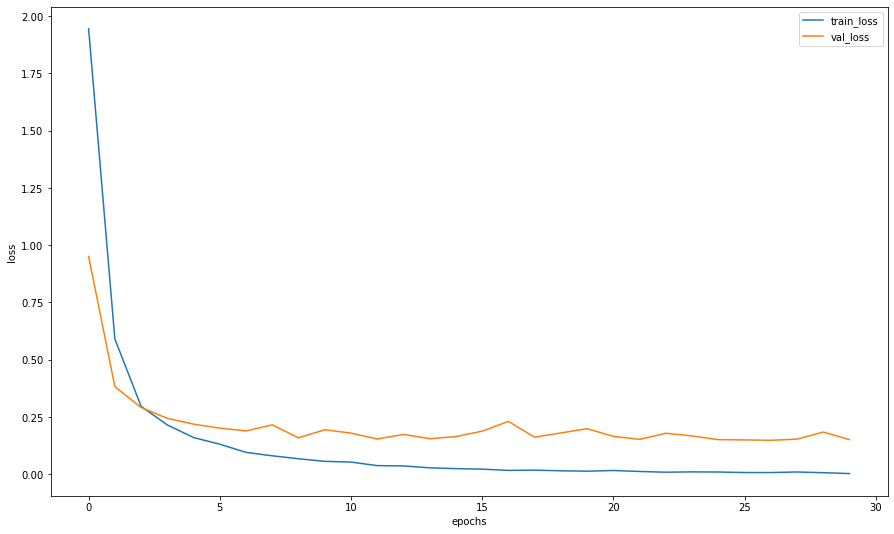


FOLD 5



epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.9268132302776055


epoch:   3%|██▌                                                                        | 1/30 [01:51<53:51, 111.45s/it]


Epoch 001 train_loss: 1.9268     val_loss 0.9780 train_acc 0.5632 val_acc 0.7868
loss 0.6119826101562352


epoch:   7%|█████                                                                      | 2/30 [03:41<51:50, 111.08s/it]


Epoch 002 train_loss: 0.6120     val_loss 0.4081 train_acc 0.8407 val_acc 0.8963
loss 0.3068593044270113


epoch:  10%|███████▌                                                                   | 3/30 [05:31<49:50, 110.76s/it]


Epoch 003 train_loss: 0.3069     val_loss 0.2753 train_acc 0.9195 val_acc 0.9372
loss 0.20650520099700348


epoch:  13%|██████████                                                                 | 4/30 [07:21<47:50, 110.42s/it]


Epoch 004 train_loss: 0.2065     val_loss 0.2662 train_acc 0.9460 val_acc 0.9356
loss 0.15896134991294517


epoch:  17%|████████████▌                                                              | 5/30 [09:11<46:00, 110.41s/it]


Epoch 005 train_loss: 0.1590     val_loss 0.2251 train_acc 0.9577 val_acc 0.9477
loss 0.12484091540052848


epoch:  20%|███████████████                                                            | 6/30 [11:01<44:05, 110.25s/it]


Epoch 006 train_loss: 0.1248     val_loss 0.2092 train_acc 0.9682 val_acc 0.9550
loss 0.09765769485777817


epoch:  23%|█████████████████▌                                                         | 7/30 [12:51<42:15, 110.26s/it]


Epoch 007 train_loss: 0.0977     val_loss 0.1886 train_acc 0.9740 val_acc 0.9593
loss 0.08302305380423909


epoch:  27%|████████████████████                                                       | 8/30 [14:41<40:24, 110.19s/it]


Epoch 008 train_loss: 0.0830     val_loss 0.1984 train_acc 0.9778 val_acc 0.9554
loss 0.0669126818334202


epoch:  30%|██████████████████████▌                                                    | 9/30 [16:32<38:33, 110.18s/it]


Epoch 009 train_loss: 0.0669     val_loss 0.1829 train_acc 0.9822 val_acc 0.9598
loss 0.053664697039083095


epoch:  33%|████████████████████████▋                                                 | 10/30 [18:22<36:42, 110.14s/it]


Epoch 010 train_loss: 0.0537     val_loss 0.2014 train_acc 0.9852 val_acc 0.9580
loss 0.04244218180301801


epoch:  37%|███████████████████████████▏                                              | 11/30 [20:12<34:55, 110.27s/it]


Epoch 011 train_loss: 0.0424     val_loss 0.1843 train_acc 0.9883 val_acc 0.9650
loss 0.03233289258210983


epoch:  40%|█████████████████████████████▌                                            | 12/30 [22:02<33:02, 110.15s/it]


Epoch 012 train_loss: 0.0323     val_loss 0.2076 train_acc 0.9915 val_acc 0.9591
loss 0.036147620046839996


epoch:  43%|████████████████████████████████                                          | 13/30 [23:52<31:13, 110.20s/it]


Epoch 013 train_loss: 0.0361     val_loss 0.1807 train_acc 0.9905 val_acc 0.9657
loss 0.03597316018968974


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [25:43<29:23, 110.19s/it]


Epoch 014 train_loss: 0.0360     val_loss 0.1977 train_acc 0.9894 val_acc 0.9598
loss 0.025552377055879406


epoch:  50%|█████████████████████████████████████                                     | 15/30 [27:33<27:32, 110.17s/it]


Epoch 015 train_loss: 0.0256     val_loss 0.1735 train_acc 0.9932 val_acc 0.9666
loss 0.017995552932136165


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [29:23<25:42, 110.16s/it]


Epoch 016 train_loss: 0.0180     val_loss 0.2083 train_acc 0.9952 val_acc 0.9598
loss 0.019842657125445945


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [31:16<24:02, 110.96s/it]


Epoch 017 train_loss: 0.0198     val_loss 0.2001 train_acc 0.9945 val_acc 0.9641
loss 0.018166608663796015


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [33:07<22:12, 111.07s/it]


Epoch 018 train_loss: 0.0182     val_loss 0.2445 train_acc 0.9951 val_acc 0.9559
loss 0.015477941650631325


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [34:57<20:18, 110.79s/it]


Epoch 019 train_loss: 0.0155     val_loss 0.1818 train_acc 0.9957 val_acc 0.9701
loss 0.01294012630671084


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [36:47<18:25, 110.53s/it]


Epoch 020 train_loss: 0.0129     val_loss 0.1774 train_acc 0.9963 val_acc 0.9696
loss 0.012590519078490752


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [38:48<17:02, 113.62s/it]


Epoch 021 train_loss: 0.0126     val_loss 0.1662 train_acc 0.9962 val_acc 0.9705
loss 0.009769875415175863


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [40:48<15:24, 115.55s/it]


Epoch 022 train_loss: 0.0098     val_loss 0.2158 train_acc 0.9972 val_acc 0.9641
loss 0.011265308498726707


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [42:41<13:22, 114.69s/it]


Epoch 023 train_loss: 0.0113     val_loss 0.1989 train_acc 0.9971 val_acc 0.9676
loss 0.009581692378009552


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [44:32<11:22, 113.72s/it]


Epoch 024 train_loss: 0.0096     val_loss 0.1814 train_acc 0.9974 val_acc 0.9694
loss 0.007157817368928105


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [46:24<09:25, 113.09s/it]


Epoch 025 train_loss: 0.0072     val_loss 0.1888 train_acc 0.9978 val_acc 0.9703
loss 0.0025240160682747114


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [48:16<07:31, 112.96s/it]


Epoch 026 train_loss: 0.0025     val_loss 0.1813 train_acc 0.9995 val_acc 0.9746
loss 0.0019142485835892409


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [50:11<05:40, 113.38s/it]


Epoch 027 train_loss: 0.0019     val_loss 0.1788 train_acc 0.9996 val_acc 0.9733
loss 0.002456192858596952


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [52:16<03:54, 117.01s/it]


Epoch 028 train_loss: 0.0025     val_loss 0.1742 train_acc 0.9995 val_acc 0.9751
loss 0.001367957410856024


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [54:12<01:56, 116.73s/it]


Epoch 029 train_loss: 0.0014     val_loss 0.1789 train_acc 0.9997 val_acc 0.9737
loss 0.0014013217422905895


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [56:05<00:00, 112.18s/it]


Epoch 030 train_loss: 0.0014     val_loss 0.1808 train_acc 0.9997 val_acc 0.9744


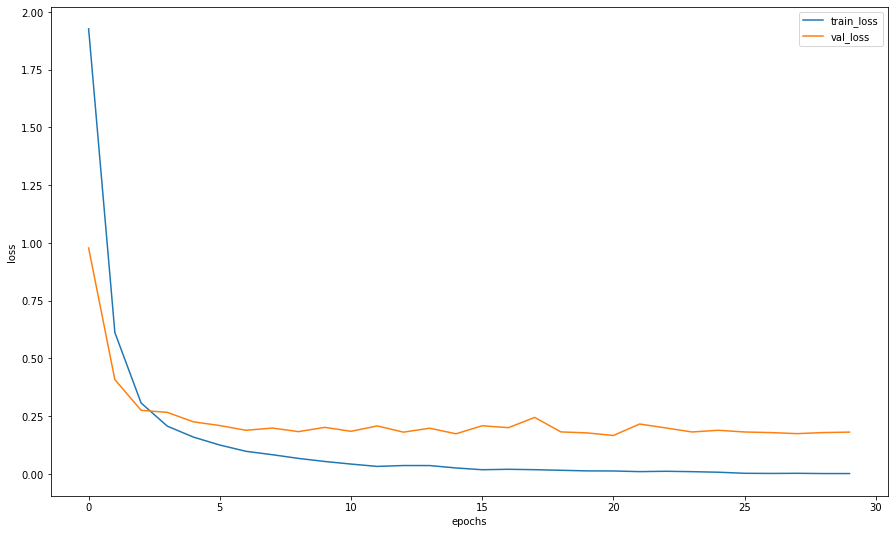

In [10]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = models.resnet18(pretrained=True)
    clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
    clf = clf.to('cuda')
        
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))    
    submit[f'fold_{fold+1}'] = preds    

In [ ]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('./out/submission.csv', index=False)
submit.head()

,Id,fold_1,fold_2,fold_3,fold_4,fold_5,Expected
0,img0.jpg,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz
1,img1.jpg,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders
3,img100.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon
